Correlation Heatmap

In [20]:
import pandas as pd
cleaned_data = pd.read_csv("Airbnb_Open_Data_cleaned.csv")

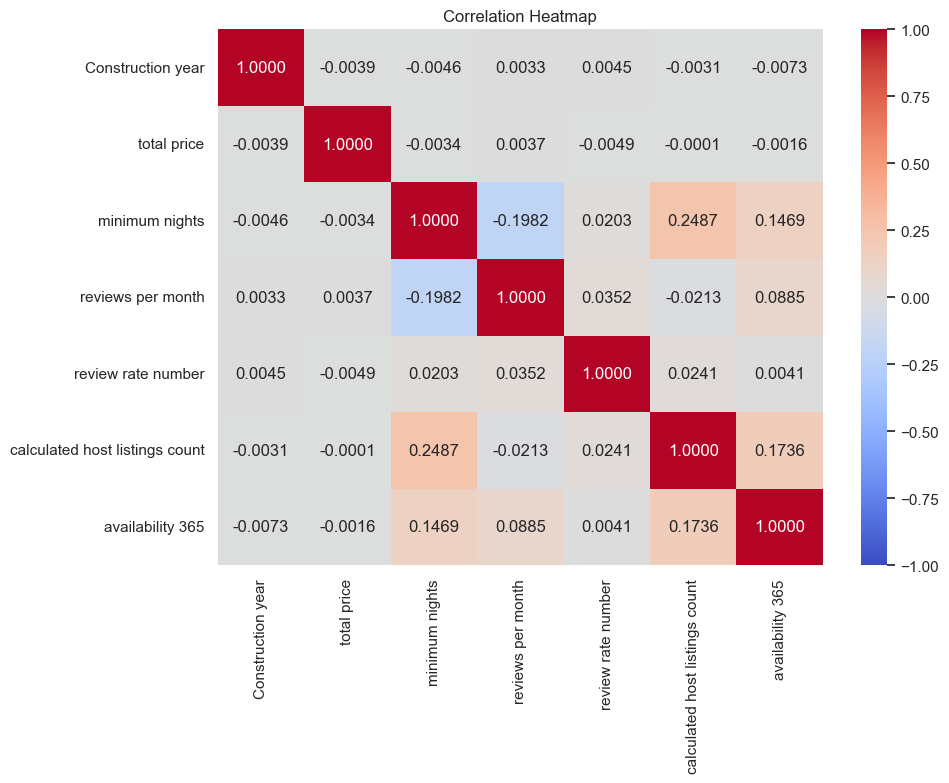

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="white")
except ImportError:
    sns = None

numeric_cols = [
    "Construction year",
    "total price",
    "minimum nights",
    "number of reviews",
    "reviews per month",
    "review rate number",
    "calculated host listings count",
    "availability 365",
]

existing_numeric = [c for c in numeric_cols if c in cleaned_data.columns]
if not existing_numeric:
    print("No numeric columns found for correlation heatmap.")
else:
    corr_matrix = cleaned_data[existing_numeric].apply(pd.to_numeric, errors="coerce").corr()

    plt.figure(figsize=(10, 8))
    if sns is not None:
        sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap="coolwarm", vmin=-1, vmax=1)
    else:
        plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar()
        plt.xticks(range(len(existing_numeric)), existing_numeric, rotation=45, ha="right")
        plt.yticks(range(len(existing_numeric)), existing_numeric)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()


FP-Growth

In [22]:
import sys
!{sys.executable} -m pip install pyfpgrowth

In [23]:
import pandas as pd
import pyfpgrowth

if "cleaned_data" not in globals():
    cleaned_data = pd.read_csv("Airbnb_Open_Data_cleaned.csv")

categorical_cols = [
    "host_identity_verified",
    "neighbourhood group",
    "instant_bookable",
    "cancellation_policy",
    "room type",
]

existing_cat = [c for c in categorical_cols if c in cleaned_data.columns]
transactions = []
for _, row in cleaned_data[existing_cat].astype("string").iterrows():
    items = [f"{col}={row[col]}" for col in existing_cat if pd.notna(row[col])]
    transactions.append(items)

# min_support is absolute count here
min_support = int(0.05 * len(transactions))
patterns = pyfpgrowth.find_frequent_patterns(transactions, min_support)
rules = pyfpgrowth.generate_association_rules(patterns, 0.6)  # min confidence

# Keep only 1->1 pairs
pairs = []
for antecedent, (consequent, confidence) in rules.items():
    if len(antecedent) == 1 and len(consequent) == 1:
        pairs.append((antecedent[0], consequent[0], confidence))

pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
pairs

[]

Normalisation 

In [ ]:
# Normalisation and encoding

def _pick_column(df, candidates):
    for name in candidates:
        if name in df.columns:
            return name
    return None

# host_identity_verified: unconfirmed=0, verified=1
host_col = _pick_column(cleaned_data, ["host_identity_verified", "host identity verified"])
if host_col is not None:
    host_map = {"unconfirmed": 0, "verified": 1}
    cleaned_data["host_identity_verified_num"] = (
        cleaned_data[host_col]
        .astype("string")
        .str.strip()
        .str.lower()
        .map(host_map)
    )

# Min-max normalization for numeric columns
numeric_cols = [
    "reviews per month",
    "review rate number",
    "total price"
]

for col in numeric_cols:
    if col not in cleaned_data.columns:
        continue
    values = pd.to_numeric(cleaned_data[col], errors="coerce")
    min_val = values.min(skipna=True)
    max_val = values.max(skipna=True)
    denom = (max_val - min_val) if pd.notna(max_val) and pd.notna(min_val) else None

    norm_col = f"{col}_norm"
    if denom and denom != 0:
        cleaned_data[norm_col] = (values - min_val) / denom
    else:
        cleaned_data[norm_col] = pd.NA

cleaned_data[[c for c in cleaned_data.columns if c.endswith("_num") or c.endswith("_norm")]].head()


,host_identity_verified_num,cancellation_policy_num,reviews per month_norm,review rate number_norm,calculated host listings count_norm,total price_norm,Construction year_norm
0,0,0.0,0.002222,0.75,0.015106,0.796377,0.894737
1,1,0.5,0.004112,0.75,0.003021,0.079710,0.210526
2,1,1.0,0.015173,1.00,0.000000,0.495652,0.105263
3,0,0.5,0.051450,0.75,0.000000,0.276812,0.105263
4,1,0.5,0.001000,0.50,0.000000,0.134058,0.315789


Score

In [25]:
# Create weighted score column
score_features = {
    "host_identity_verified_num": 0.2,
    "total price_norm": 0.2,
    "cancellation_policy_num": 0.1,
    "Construction year_norm": 0.1,
    "reviews per month_norm": 0.1,
    "review rate number_norm": 0.2,
    "calculated host listings count_norm": 0.1,
}

existing_features = [c for c in score_features if c in cleaned_data.columns]
if not existing_features:
    raise KeyError("No score feature columns found. Run the normalization/encoding cell first.")

weights = pd.Series({k: score_features[k] for k in existing_features})
values = cleaned_data[existing_features].apply(pd.to_numeric, errors="coerce")

weighted_sum = values.mul(weights, axis=1).sum(axis=1, skipna=True)
weight_sum = values.notna().mul(weights, axis=1).sum(axis=1)

cleaned_data["score"] = weighted_sum.div(weight_sum).where(weight_sum != 0)

cleaned_data[["score"] + existing_features].head()


,score,host_identity_verified_num,total price_norm,cancellation_policy_num,Construction year_norm,reviews per month_norm,review rate number_norm,calculated host listings count_norm
0,0.400482,0,0.796377,0.0,0.894737,0.002222,0.75,0.015106
1,0.437708,1,0.079710,0.5,0.210526,0.004112,0.75,0.003021
2,0.611174,1,0.495652,1.0,0.105263,0.015173,1.00,0.000000
3,0.271034,0,0.276812,0.5,0.105263,0.051450,0.75,0.000000
4,0.408491,1,0.134058,0.5,0.315789,0.001000,0.50,0.000000


In [26]:
# Score category
if "score" not in cleaned_data.columns:
    raise KeyError("Column 'score' not found. Run the score calculation cell first.")

score_bins = [0, 0.6, 0.8, 1]
score_labels = ["Risky", "Standard", "Elite"]

cleaned_data["score_category"] = pd.cut(
    pd.to_numeric(cleaned_data["score"], errors="coerce"),
    bins=score_bins,
    labels=score_labels,
    include_lowest=True,
)

cleaned_data[["score", "score_category"]].head()


,score,score_category
0,0.400482,Risky
1,0.437708,Risky
2,0.611174,Standard
3,0.271034,Risky
4,0.408491,Risky


In [27]:
# Training dataframe: normalized columns + score + score category (first 80%)
normalized_cols = [c for c in cleaned_data.columns if c.endswith("_norm")]
required_cols = normalized_cols + ["score", "score_category"]

missing = [c for c in required_cols if c not in cleaned_data.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Run normalization/score cells first.")

train_rows = int(len(cleaned_data) * 0.8)
train_df = cleaned_data[required_cols].iloc[:train_rows].copy()

# Save training data
train_df.to_csv("training_data.csv", index=False)

train_df.head()

,reviews per month_norm,review rate number_norm,calculated host listings count_norm,total price_norm,Construction year_norm,score,score_category
0,0.002222,0.75,0.015106,0.796377,0.894737,0.400482,Risky
1,0.004112,0.75,0.003021,0.079710,0.210526,0.437708,Risky
2,0.015173,1.00,0.000000,0.495652,0.105263,0.611174,Standard
3,0.051450,0.75,0.000000,0.276812,0.105263,0.271034,Risky
4,0.001000,0.50,0.000000,0.134058,0.315789,0.408491,Risky


In [28]:
# Decision Tree model (classification)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Build test set from the remaining 20%
test_df = cleaned_data[required_cols].iloc[train_rows:].copy()

# Drop rows with missing values in features/target
train_df = train_df.dropna(subset=required_cols)
test_df = test_df.dropna(subset=required_cols)

X_train = train_df[normalized_cols]
y_train = train_df["score_category"]
X_test = test_df[normalized_cols]
y_test = test_df["score_category"]

clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_leaf=10,
)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

# Save test results with predictions
results_df = test_df.copy()
results_df["predicted_category"] = pred
results_df.to_csv("test_results.csv", index=False)


Accuracy: 0.8946698020772095
              precision    recall  f1-score   support

       Risky       0.91      0.98      0.94     18284
    Standard       0.48      0.15      0.22      2128

    accuracy                           0.89     20412
   macro avg       0.70      0.56      0.58     20412
weighted avg       0.86      0.89      0.87     20412

[[17951   333]
 [ 1817   311]]
